In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.head())

                                             message label
0  I saw this movie in NEW York city. I was waiti...   neg
1  This is a German film from 1974 that is someth...   neg
2  I attempted watching this movie twice and even...   neg
3  On his birthday a small boys tells his mother ...   neg
4  The person who wrote the review "enough with t...   pos


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Descargar recursos necesarios de NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
    
    return ' '.join(tokens)

train['clean_message'] = train['message'].apply(preprocess_text)

# Save the cleaned text to a new CSV file
train.to_csv('train_clean.csv', index=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vilch\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vilch\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vilch\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

train = pd.read_csv('train_clean.csv')

X_train, X_test, y_train, y_test = train_test_split(train['clean_message'], train['label'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(X_train_tfidf.shape)

(20000, 58354)


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
# Inicializar los clasificadores
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='saga', verbose=1),
}

# Entrenar, predecir y evaluar cada clasificador
for name, clf in classifiers.items():
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_test_tfidf)
    
    print(f"Results for {name}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("\n")

convergence after 19 epochs took 0 seconds
Results for Logistic Regression:
Accuracy: 0.883
Classification Report:
               precision    recall  f1-score   support

         neg       0.89      0.87      0.88      2446
         pos       0.88      0.89      0.89      2554

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000





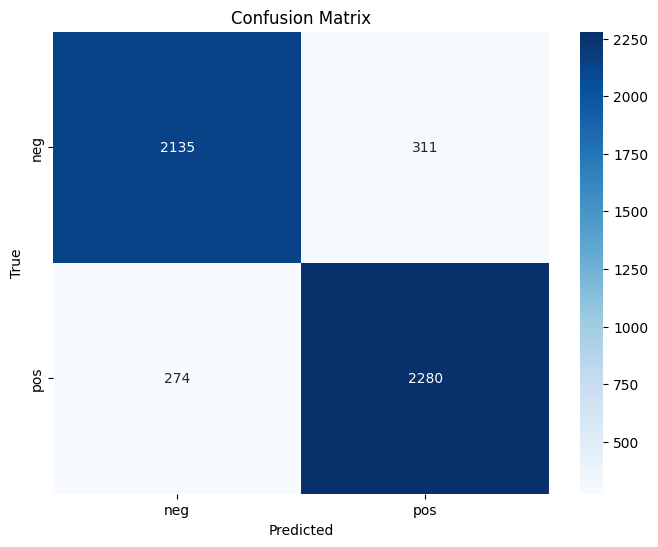

In [12]:
# Graficar la matriz de confusión con seaborn
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
# Predecir con test

test = pd.read_csv('test.csv')
test['clean_message'] = test['message'].apply(preprocess_text)
X_test = vectorizer.transform(test['clean_message'])

# Predecir con el mejor clasificador
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)
test['label'] = clf.predict(X_test)

submission = {
    'ids': [i for i in range(len(test))],
    'label': test['label']
}

submission_df = pd.DataFrame(submission)
submission_df.to_csv('submission.csv', index=False)
